<div style="float: right; width: 70%; height: 150px;">
  <div style="position: relative; top: 20%;padding-right:20%;">
  <div style="font-size:280%;font-weight: bold;padding-top: 20px;"> CCREM</div>
  <div style="font-size:180%;font-weight: bold;padding-top: 20px;color: rgba(0 , 0 , 0 , 0.5);"> 1D reference model from coda-correlations</div>
  </div>
</div>

This script will use CCREM and the obspy taup tool for predicting travel times.

In [1]:
from __future__ import print_function
import os,sys

# for fixed plots
%matplotlib inline
# for interactive plots
#%matplotlib notebook

import matplotlib as mpl
print("matplotlib version: ",mpl.__version__)

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 20, 5
plt.rcParams['lines.linewidth'] = 0.5

matplotlib version:  3.4.2


uses obspy<br>
http://docs.obspy.org<br>
a python framework for seismology

In [2]:
import obspy
print("obspy version: ",obspy.__version__)

obspy version:  1.2.2


In [3]:
from obspy.taup import TauPyModel
from obspy.taup import taup_create

print("creating model CCREM")

# creates taup model for CCREM file
taup_create.build_taup_model('./ccrem.nd',output_folder='./',verbose=True)


creating model CCREM
Building obspy.taup model for './ccrem.nd' ...


In [4]:
# read in model
flattening = 0.0  # Spherically-symmetric Earth models all have the same hydrostatic surface ellipticity 1/299.8

model = TauPyModel(model="./ccrem.npz",verbose=True,planet_flattening=flattening)

# check
model.model.validate()

radius_km = model.model.radius_of_planet
print("model radius:",radius_km,"(km)")


model radius: 6371.0 (km)



## Event

Event 01:

    Event 2010/05/09 
    Latitude  Longitude  Depth(km) 
    3.748 96.018  38.0 
    
    from: https://figshare.com/articles/dataset/Event-station_zip/14702745
    

event:
  lat/lon = 3.748 / 96.018
  depth   =  38.0 (km)

station AAK: 
  lat/lon = 42.6375 / 74.4942
  epicentral distance =  43.35055903608167 (degree)

  P:  P phase arrival at 478.126 seconds
  S:  S phase arrival at 864.252 seconds



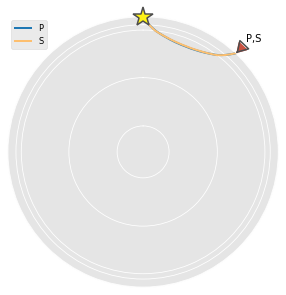

station BORG: 
  lat/lon = 64.7474 / -21.3268
  epicentral distance =  97.84075090658135 (degree)

  P:  P phase arrival at 811.572 seconds
  S:  S phase arrival at 1494.303 seconds



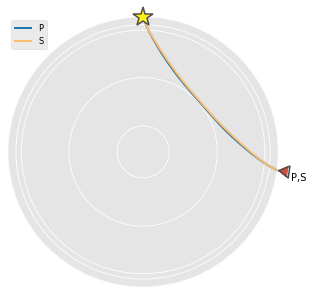

station RPN: 
  lat/lon = -27.1267 / -109.334
  epicentral distance =  146.3433240506797 (degree)

  P:  Pdiff phase arrival at 1027.982 seconds



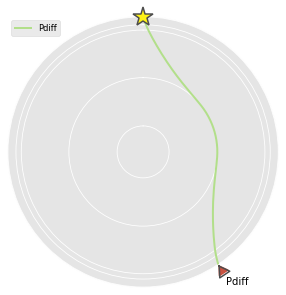

In [5]:
## epicentral distance

# event lat/lon
event_lat = 3.748
event_lon = 96.018
event_dep_km = 38.0  # event depth in km

print("event:")
print("  lat/lon = {} / {}".format(event_lat,event_lon))
print("  depth   = ",event_dep_km,"(km)")
print("")

# stations
II_AAK  = { 'name': 'AAK', 'lat': 42.6375, 'lon': 74.4942 }    # II.AAK
II_BORG = { 'name': 'BORG', 'lat': 64.7474, 'lon': -21.3268 }    # II.BORG
II_RPN  = { 'name': 'RPN', 'lat': -27.1267, 'lon': -109.3340 }    # II.RPN


stations = [ II_AAK, II_BORG, II_RPN ]

# epicentral distance (Haversine formula)
def get_epicentral_distance(event_lat,event_lon,sta_lat,sta_lon):
    from math import pi,sin,cos,asin,sqrt
    # converts to radians
    lat1_radians = event_lat * pi/180.0
    lon1_radians = event_lon * pi/180.0
    lat2_radians = sta_lat * pi/180.0
    lon2_radians = sta_lon * pi/180.0

    mid_lat = (lat1_radians - lat2_radians)/2.0
    mid_lon = (lon1_radians - lon2_radians)/2.0

    tmp = sqrt( pow(sin(mid_lat),2) + cos(lat1_radians)*cos(lat2_radians)*pow(sin(mid_lon),2) )

    distance_radians = 2.0 * asin(tmp)
    dist = distance_radians * 180.0/pi
    
    return dist

# show epicentral distances and main arrival times
for station in stations:    
    sta_lat = station['lat']
    sta_lon = station['lon']
    dist = get_epicentral_distance(event_lat,event_lon,sta_lat,sta_lon)
    
    print("station {}: ".format(station['name']))
    print("  lat/lon = {} / {}".format(sta_lat,sta_lon))
    print("  epicentral distance = ",dist,"(degree)")
    print("")

    # P, S arrival times (can have multiple P, S arrivals)
    arrivals_P = model.get_travel_times(source_depth_in_km=event_dep_km,
                                        distance_in_degree=dist, 
                                        phase_list=["ttall"])  # using 'ttall' in case Pn would be first, instead of P

    arrivals_S = model.get_travel_times(source_depth_in_km=event_dep_km,
                                        distance_in_degree=dist, 
                                        phase_list=["S"])
    
    # traveltimes for first arrivals    
    if len(arrivals_P) > 0:
        print("  P: ",arrivals_P[0])
    if len(arrivals_S) > 0:        
        print("  S: ",arrivals_S[0])
    print("")
    
    # plot rays for first arrivals
    arrivals_P = model.get_ray_paths(source_depth_in_km=event_dep_km, distance_in_degree=dist, phase_list=["ttall"])
    arrivals_S = model.get_ray_paths(source_depth_in_km=event_dep_km, distance_in_degree=dist, phase_list=["S"])
    
    arrivals = obspy.taup.tau.Arrivals([],model=model.model)
    if len(arrivals_P) > 0:
        arrivals.append(arrivals_P[0])
    if len(arrivals_S) > 0:        
        arrivals.append(arrivals_S[0])

    ax = arrivals.plot_rays(plot_type="spherical",label_arrivals=True,legend=True)
    

In [6]:
## arrival times
print("all arrival times for BORG:")
      
# takes station II.BORG
station = II_BORG
sta_lat = station['lat']
sta_lon = station['lon']

# station epicentral distance in degree
dist = get_epicentral_distance(event_lat,event_lon,sta_lat,sta_lon)

print("  source depth: {} km, distance: {}°".format(event_dep_km,dist))

#phases = ["P","PP","PPP","PPS","p","pPcP","PKIKP","PKJKP","S","SP","SS","SSS","pP","sP","ScS","SKKS"]
phases = ["ttall"]

arrivals = model.get_travel_times(source_depth_in_km=event_dep_km,
                                  distance_in_degree=dist, 
                                  phase_list=phases)

print("  all possible arrivals: ",arrivals) 

all arrival times for BORG:
  source depth: 38.0 km, distance: 97.84075090658135°
  all possible arrivals:  31 arrivals
	P phase arrival at 811.572 seconds
	PcP phase arrival at 811.646 seconds
	pP phase arrival at 822.794 seconds
	sP phase arrival at 827.056 seconds
	PP phase arrival at 1048.938 seconds
	PKiKP phase arrival at 1084.613 seconds
	pPKiKP phase arrival at 1096.196 seconds
	sPKiKP phase arrival at 1100.381 seconds
	SKiKP phase arrival at 1296.489 seconds
	SKS phase arrival at 1445.438 seconds
	pSKS phase arrival at 1460.825 seconds
	sSKS phase arrival at 1465.113 seconds
	SKKS phase arrival at 1473.058 seconds
	S phase arrival at 1494.303 seconds
	ScS phase arrival at 1494.627 seconds
	pS phase arrival at 1508.869 seconds
	sS phase arrival at 1513.402 seconds
	SP phase arrival at 1576.918 seconds
	PS phase arrival at 1581.730 seconds
	PKKP phase arrival at 1805.042 seconds
	PKIKKIKP phase arrival at 1807.445 seconds
	SS phase arrival at 1896.412 seconds
	SKIKKIKP phase arr

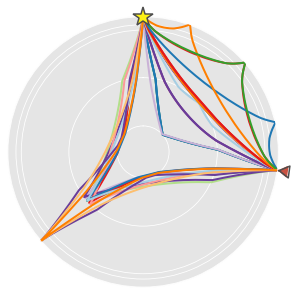

In [7]:
arrivals = model.get_ray_paths(source_depth_in_km=event_dep_km, 
                               distance_in_degree=dist, 
                               phase_list=phases)
ax = arrivals.plot_rays()

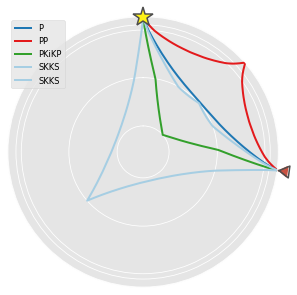

In [14]:
arrivals = model.get_ray_paths(source_depth_in_km=event_dep_km,
                               distance_in_degree=dist,
                               phase_list=["P","PP", "PKiKP", "SKKS"])  # 
ax = arrivals.plot_rays(plot_type="spherical", legend=True)

done. 